# Anomalies Detection Using Contrastive Learning (Photons-Electrons) 

Electrons and Photons are very similar in their energies and distributions. Using Classical classification methods like CNN can achieve in the best cases around 72-84% of AUC. We tried many ways of classifying these signals using Variational Autoencoders (VAE), Convolutional Variational Autoencoders (CVAE), Contrastive Learning, Graphs, Sparse Classification with ResNet or other transfer learning approaches, and Deep Autoencoders. All of these methods achieved similar results. And when trying to apply these methods to anomaly detection, things become worse as shown in this figure, the two classes are overlapped in the latent space of a CVAE.


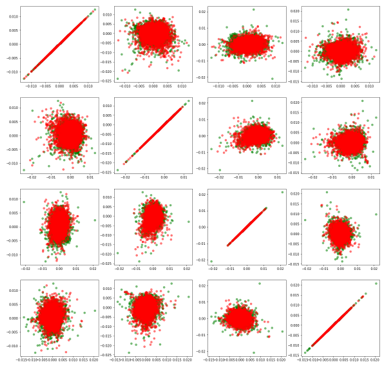

We depend on the model existing in https://keras.io/examples/vision/siamese_contrastive/ to detect the anomalies. But without using the contrastive loss which doesn't perform well, and without using the augmentation to provide the negative samples because it doesn't provide good results as well. We also have one positive class so we generated the negative samples by using one of the top quark channels after cropping the output of this channel to be of equal size to the Photons.

Siamese Network tries to minimize the distances between pairs from similar class and maximize it between pairs from different samples. 
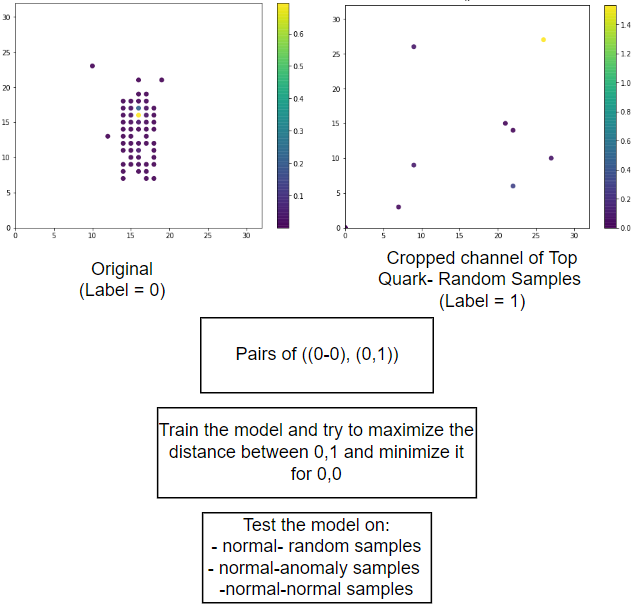

GPU

In [16]:
doGPU = True
if doGPU:
    import tensorflow as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config =tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.compat.v1.Session())

Importing the Modules

In [17]:
import numpy as np
import pandas as pd
import torch
from tensorflow import keras
import pyarrow.parquet as pq
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import keras.backend
from scipy.stats import norm
from keras.layers import Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import random

Loading and Preparing the data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [19]:
!cd '/content/gdrive/My Drive/parquets'

In [20]:
datasets = pq.ParquetFile(f"/content/gdrive/My Drive/parquets/Boosted_Jets_Sample-{1}.snappy.parquet")

In [21]:
top =[]
for i in range(0,21000):
  data = datasets.read_row_group(i, columns=None).to_pydict()
  data = np.float32(data['X_jets'][0])
  data = data[0,:,:] #take only the first channel
  data = data[52:84,52:84] #cropping the data to size 32x32 
  top.append (data)

In [22]:
!mkdir Particle_Images
!cd Particle_Images
!mkdir data/
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

mkdir: cannot create directory ‘Particle_Images’: File exists
mkdir: cannot create directory ‘data/’: File exists
--2022-09-25 19:05:52--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  11.2MB/s    in 9.1s    

Last-modified header invalid -- time-stamp ignored.
2022-09-25 19:06:04 (9.09 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2022-09-25 19:06:04--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (ce

In [23]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
normal = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1']
anomalies = ['SingleElectronPt50_IMGCROPS_n249k_RHv1']
def load_data(decays):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'] for dset in dsets])
    y = np.concatenate([dset['/y'] for dset in dsets])
    assert len(X) == len(y)
    return X, y


X_train, Y_train = load_data(normal)

In [24]:
X_train= X_train[:,:,:,0] #taking the energy channel only and ignoring the time channel

In [25]:
X_train = X_train.reshape(-1,32,32,1)

In [26]:
top = np.asarray(top).reshape(-1,32,32,1)

In [27]:
num_classes = 2 #Photon and random samples or Photons and Electrons samples
input_shape = (32, 32, 1)
epochs = 20
batch_size = 256

In [28]:
X = (np.concatenate((X_train, top))).reshape (-1,32,32)
y = [1]*(len(top))
y = np.asarray(y, dtype=np.float32)
Y = np.hstack((Y_train, y))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_Valid, Y_train, Y_Valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=50)

Plotting a Photon and Random samples

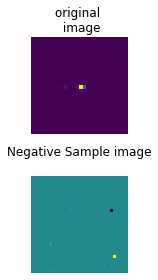

In [32]:
# Plotting an example of the cropped part from one of top quark' channels vs a photon sample
plt.subplot(2, 1, 1)
plt.title("original \n image")
plt.imshow(X_train[0].reshape(32,32))
plt.axis('off')

plt.subplot(2, 1, 2)
plt.title("Negative Sample image\n ")
plt.imshow(top[0].reshape(32,32))
plt.axis('off')
  
plt.tight_layout()
plt.show()

In [33]:
#for scatter plots 
def parse_img(arr):
  row , col = 32, 32
 
  y=[0]*np.count_nonzero(arr)
  x=[0]*np.count_nonzero(arr)
  Value=[0]*np.count_nonzero(arr)

  count =0
  for i in range (0,row):
      for j in range (0,col):
        
        if arr[i][j] > 0:
            y[count] = (j) 
            x[count] = (i)
            Value[count] = (float(arr[i][j]))
            count+=1
  return(x[:], y[:], Value[:])

def vis (img, cmap='viridis', title=''):
    plt.figure(figsize=[8,6])
    for i in range(1):
      xpos,ypos,val = parse_img(img[:,:,i])
      print (val)
      cm = plt.cm.get_cmap(cmap)
      sc = plt.scatter(xpos, ypos, c=val, cmap= cm, alpha=0.9)
      plt.colorbar(sc)
      plt.title(title)
      plt.xlim(0,32)
      plt.ylim(0,32)
      plt.show()

[0.041786033660173416, 0.10405688732862473, 0.09427572041749954, 0.028879621997475624, 0.30394282937049866, 0.025190161541104317, 1.534428358078003, 0.08636270463466644, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


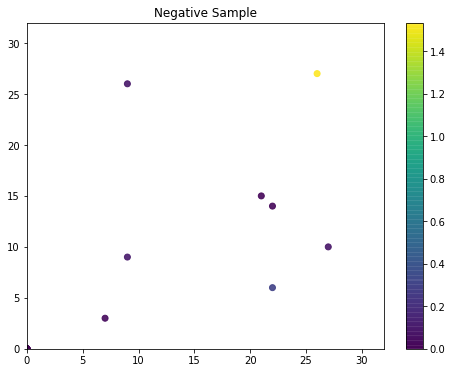

In [34]:
vis(top[0].reshape(32,32,1), title='Negative Sample')

[0.002881385385990143, 0.0019052166026085615, 0.0006735681090503931, 0.0006074097473174334, 0.0010502529330551624, 0.001351692946627736, 0.0008441181271336973, 0.0017457309877499938, 0.0020697247236967087, 0.0006167577812448144, 0.0038947868160903454, 0.0027868319302797318, 0.002468600869178772, 0.0010867612436413765, 0.0004905406967736781, 0.002391428453847766, 0.0006110300309956074, 0.003468205686658621, 0.0025856061838567257, 0.010578591376543045, 0.025228425860404968, 0.02020227164030075, 0.005591581575572491, 0.00255154212936759, 0.00973663479089737, 0.008100760169327259, 0.04020347446203232, 0.0032933070324361324, 0.002022204454988241, 0.033490292727947235, 0.695960521697998, 0.21783024072647095, 0.008039009757339954, 0.0025226667057722807, 0.0026840558275580406, 2.1891301003051922e-05, 6.149400724098086e-05, 0.000192992330994457, 0.0023603676818311214, 0.000328957277815789, 0.0020141771528869867, 0.010260599665343761, 0.025740494951605797, 0.01963551715016365, 0.0062819528393447

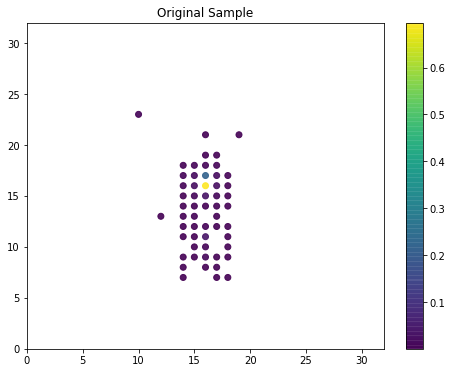

In [35]:
vis(X_train[0].reshape(32,32,1), title='Original Sample')

Making Pairs of (Photon-Photon) labeled with 1 and (Photon-Random) labeled with 0

In [ ]:
#This is the general way of generating the pairs for the contrastive learning
def make_pairs(x, y):
    num_classes = 2
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = int(y[idx1])
        if (label1 == 0): #to not generate random with random pairs
          idx2 = random.choice(digit_indices[label1])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [1]

          # add a non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
              label2 = random.randint(0, num_classes - 1)

          idx2 = random.choice(digit_indices[label2])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
# make train, test, and valid pairs
pairs_train, labels_train = make_pairs(X_train, Y_train)
pairs_Valid, labels_Valid = make_pairs(X_Valid, Y_Valid)
pairs_test, labels_test = make_pairs(X_test, Y_test)

In [ ]:
#Splitting the pairs because the siamese will take the pair as two inputs 

x_train_1 = pairs_train[:, 0] 
x_train_2 = pairs_train[:, 1]

x_Valid_1 = pairs_Valid[:, 0] 
x_Valid_2 = pairs_Valid[:, 1]

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]

Building the model, defining the metrics, and training the model

In [ ]:
# Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

#model ref: https://keras.io/examples/vision/siamese_contrastive/ 
input = layers.Input((32, 32, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
#x = layers.Dense(100, activation="relu")(x)
#x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((32, 32, 1))
input_2 = layers.Input((32, 32, 1))

# Siamese Network share weights of embedded samples
Lat1 = embedding_network(input_1)
Lat2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([Lat1, Lat2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
siamese.compile(loss=keras.losses.MeanAbsoluteError(), optimizer="Adam", metrics=["accuracy"]) #we didn't use the known contrastive loss
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           7334        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [ ]:
x_train_1 = x_train_1.reshape(-1,32,32,1)
x_train_2 = x_train_2.reshape(-1,32,32,1)

x_Valid_1 = x_Valid_1.reshape(-1,32,32,1)
x_Valid_2 = x_Valid_2.reshape(-1,32,32,1)

x_test_1 = x_test_1.reshape(-1,32,32,1)
x_test_2 = x_test_2.reshape(-1,32,32,1)

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_Valid_1, x_Valid_2], labels_Valid),
    batch_size=batch_size,
    shuffle = True,
    epochs=20,
)

Epoch 1/20
1059/1059 [==============================] - 21s 8ms/step - loss: 0.0710 - accuracy: 0.9938 - val_loss: 0.0170 - val_accuracy: 0.9927
Epoch 2/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0100 - accuracy: 0.9992 - val_loss: 0.0056 - val_accuracy: 0.9970
Epoch 3/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9977
Epoch 4/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0073 - val_accuracy: 0.9933
Epoch 5/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9969
Epoch 6/20
1059/1059 [==============================] - 8s 8ms/step - loss: 9.9670e-04 - accuracy: 0.9993 - val_loss: 0.0084 - val_accuracy: 0.9920
Epoch 7/20
1059/1059 [==============================] - 8s 7ms/step - loss: 8.4820e-04 - accuracy: 0.9994 - val_loss: 0.0046 - val_

Evaluating the model

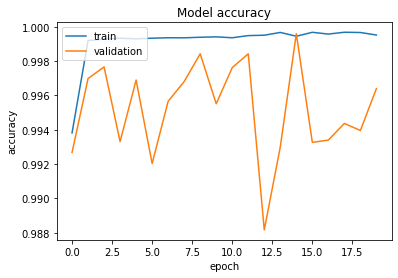

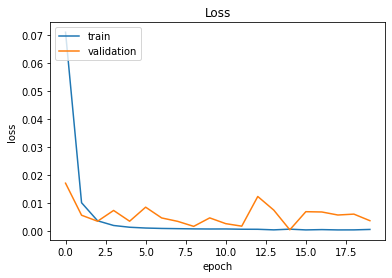

In [ ]:
def plt_metric(history, metric, title):

    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the MAE loss
plt_metric(history=history.history, metric="loss", title="MAE Loss")

In [ ]:
#testing the model based on Photon-Photon and Photon-Random
siamese.evaluate([x_test_1, x_test_2], labels_test)

2641/2641 [==============================] - 7s 3ms/step - loss: 0.0027 - accuracy: 0.9973


[0.0027358795050531626, 0.9972894191741943]

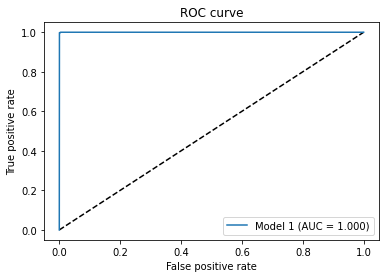

In [ ]:
y_pred_proba = siamese.predict([x_test_1, x_test_2])
fpr, tpr, _ = roc_curve(labels_test,  y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 (AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Removing the random samples from the testing data 
anom_mask = (Y_test==1)
y =[]
X_test = X_test[~anom_mask]
Y_test = Y_test[~anom_mask]
#Loading the Electrons datasest
anomaly_test, y = load_data(anomalies)
#Creating new testing dataset
X = (np.concatenate((X_test, anomaly_test.reshape (-1,32,32))))
y = [1]*(len(anomaly_test))
y = np.asarray(y, dtype=np.float32)
Y = np.hstack((Y_test, y))

In [ ]:
def make_new_pairs(x, y):
    num_classes = 2
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(253841):
        # make Photon-Photon pairs 
        x1 = x[idx1]
        label1 = int(y[idx1])
        if (label1 == 0):
          idx2 = random.choice(digit_indices[label1])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [1]

            #make Photon-Electron pairs
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
              label2 = random.randint(0, num_classes - 1)

          idx2 = random.choice(digit_indices[label2])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
pairs, labels = make_new_pairs(X, Y)

x_testn = pairs[:, 0] 
x_testn2 = pairs[:, 1]

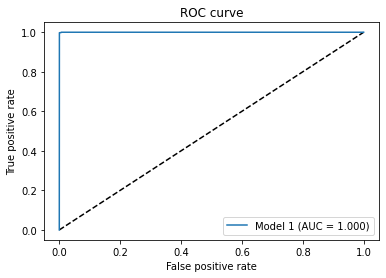

In [ ]:
y_pred_proba = siamese.predict([x_testn, x_testn2])
fpr, tpr, _ = roc_curve(labels,  y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 (AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#checking the prediction values
y_pred_proba

array([[1.0000000e+00],
       [1.4708778e-17],
       [1.0000000e+00],
       ...,
       [5.4316498e-20],
       [1.0000000e+00],
       [4.3475785e-24]], dtype=float32)

In [ ]:
#Evaluating the model based on Photon-Photon and Photon-Electron datasets
siamese.evaluate([x_testn, x_testn2], labels)

2641/2641 [==============================] - 9s 3ms/step - loss: 0.0028 - accuracy: 0.9972


[0.002788472454994917, 0.9972184300422668]

In [ ]:
#Testing the model using the same input 
siamese.predict([x_testn, x_testn])

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
#Just to make sure that the model doesn't learn a pattern for the predictions, we did this test many times on different samples
xnew = x_testn[0:1]
xnew2 = x_testn2 [1:2]

In [ ]:
siamese.predict([xnew, xnew2])

array([[1.4708611e-17]], dtype=float32)